# Setup and Data Loading

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

In [106]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


# Preprocess

In [5]:
# Text Vectorization
from tensorflow.keras.layers import TextVectorization

In [7]:
X = df['comment_text']
X.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [12]:
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
y # numpy array

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [19]:
MAX_FEATURES = 200000 # Maximum number of words in the vocabulary

In [23]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=1800, output_mode='int') 
# output_sequence_length is the maximum length of the output sequences
# output_mode is the type of output (int, binary, count, tf-idf)
# int is used for classification
# binary is used for binary classification
# count is used for counting the number of times a word appears in a document
# tf-idf is used for term frequency-inverse document frequency

In [24]:
vectorizer.adapt(X.values) 
# fitting the vectorizer to the data
# this will build the vocabulary

In [32]:
len(vectorizer.get_vocabulary())

200000

In [28]:
# Example of vectorization
vectorizer('hello world')[:2]

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([288, 263], dtype=int64)>

In [29]:
# vectorizing the data
vectorized_text = vectorizer(X.values)

In [30]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [31]:
vectorized_text.shape

TensorShape([159571, 1800])

In [36]:
# MCSHBAP - map, cache, shuffle, batch, prefetch
# from_tensor_slices - creates a dataset from a tensor
# list_files - creates a dataset from a list of files
# image_dataset_from_directory - creates a dataset from a directory of images
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [41]:
# total number of batches
len(list(dataset))

9974

In [42]:
# number of data in single batch
for batch in dataset.take(1):
    print(len(batch[0]))

16


In [44]:
batch_X, batch_y = next(iter(dataset))

In [45]:
batch_X

<tf.Tensor: shape=(16, 1800), dtype=int64, numpy=
array([[  176,  7511,   233, ...,     0,     0,     0],
       [24208,   121,    22, ...,     0,     0,     0],
       [    2,    24,   507, ...,     0,     0,     0],
       ...,
       [20321,   797,     8, ...,     0,     0,     0],
       [ 3516,  7324,  4602, ...,     0,     0,     0],
       [  387,   972,    70, ...,     0,     0,     0]], dtype=int64)>

In [50]:
# Splitting the data
train = dataset.take(int(0.7 * len(list(dataset))))
val = dataset.skip(int(0.7 * len(list(dataset)))).take(int(0.2 * len(list(dataset))))
test = dataset.skip(int(0.9 * len(list(dataset)))).take(int(0.1 * len(list(dataset))))

In [51]:
len(train), len(test), len(val)

(6981, 997, 1994)

In [53]:
train_generator = train.as_numpy_iterator()

In [55]:
train_generator.next()

(array([[433, 265,  35, ...,   0,   0,   0],
        [ 70,  15,   1, ...,   0,   0,   0],
        [ 27,  54,  43, ...,   0,   0,   0],
        ...,
        [ 94, 110,  59, ...,   0,   0,   0],
        [  3, 290,  10, ...,   0,   0,   0],
        [ 70,  15,  95, ...,   0,   0,   0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

# Creating a Sequential Model

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Embedding
# Dropout is used to prevent overfitting, method of regularization
# Bidirectional is used to learn from both directions, forward and backward, of the sequence of data
# LSTM is used to learn from the sequence of data, it is a type of RNN
# Dense is used to create a fully connected layer
# Sequential is used to create a model
# Embedding is used to create a word embedding layer, it is used to convert words into vectors, it is used in NLP

In [74]:
model = Sequential()

model.add(Embedding(MAX_FEATURES+1, 32)) 
# 32 is the dimension of the word embeddings, +1 is used to add 1 to the maximum number of words in the vocabulary, this is used to avoid errors, it is a common practice
# why 32? - 32 is a common value for the dimension of word embeddings
# what is an embedding? - an embedding is a mapping of words to vectors
# what is the purpose of an embedding? - the purpose of an embedding is to convert words into vectors
# what is the benefit of an embedding? - the benefit of an embedding is that it can capture the semantic meaning of words
# what is the difference between an embedding and a one-hot encoding? - an embedding is a dense representation of words, a one-hot encoding is a sparse representation of words
# so 32 is the number of dimensions in the embedding layer, which means that each word will be represented by a vector of 32 dimensions, 
# each of the dimensions in the vector will represent a different aspect of the word, for example, the first dimension could represent the length of the word, the second dimension could represent the frequency of the word, the third dimension could represent the part of speech of the word, etc.
# the embedding layer is a type of hidden layer, it is used to learn the relationship between words, it is used to convert words into vectors, it is used to convert words into a format that can be used by a neural network
# the embedding layer is a type of input layer, it is used to convert words into vectors, it is used to convert words into a format that can be used by a neural network

model.add(Bidirectional(LSTM(32, activation='tanh'))) 
# 32 is the number of units in the LSTM layer, tanh is the activation function
# it is bidirectional because it learns from both directions of the sequence of data
# it is a type of RNN, it is used to learn from the sequence of data
# LSTM is used with Bidirectional because it is a type of RNN, it is used to learn from the sequence of data, it is used to learn the relationship between words
# tanh is the activation function, it is used to introduce non-linearity into the model, it is used to learn complex patterns in the data
# for LSTM, tanh is a common activation function, it is used to learn the relationship between words

model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Fully connected layers

model.add(Dense(6, activation='sigmoid'))
# Output layer, 6 is the number of classes, sigmoid is the activation function

In [75]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [79]:
history = model.fit(train.take(10), epochs=10, validation_data=val.take(5)) # weak model, only 10 batches

Epoch 1/10


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.1261 - val_loss: 0.2157
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.1120 - val_loss: 0.1521
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.1659 - val_loss: 0.1565
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.1693 - val_loss: 0.2212
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.1627 - val_loss: 0.1728
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.1750 - val_loss: 0.1286
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.1969 - val_loss: 0.1161
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.1777 - val_loss: 0.1431
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.0892 - val_loss: 0.0988
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.1190 - val_loss: 0.2539


In [ ]:
# train in colab
# history = model.fit(train, epochs=10, validation_data=val) # Im not running this because it will take a long time

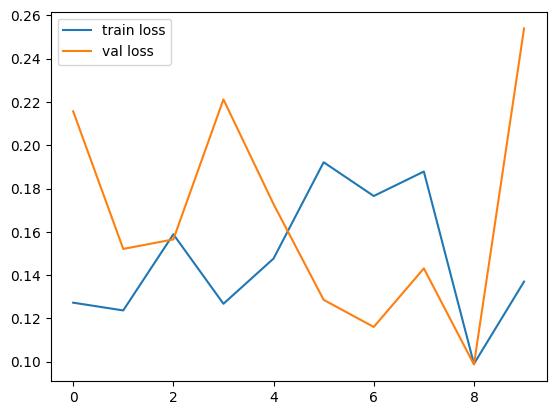

In [80]:
from matplotlib import pyplot as plt
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# Make Predictions

In [81]:
input_text = vectorizer('You suck at this')

In [82]:
input_text = tf.expand_dims(input_text, 0)

In [83]:
input_text

<tf.Tensor: shape=(1, 1800), dtype=int64, numpy=array([[  7, 397,  34, ...,   0,   0,   0]], dtype=int64)>

In [84]:
result = model.predict(input_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


In [85]:
result

array([[0.12031781, 0.01351526, 0.08720271, 0.00710226, 0.04396067,
        0.01045791]], dtype=float32)

In [86]:
# predict on a batch
batch_X, batch_y = next(iter(test))

In [87]:
result = model.predict(batch_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


In [88]:
# convert the result to binary
result = (result > 0.5).astype(int)

In [89]:
# compare the result with the actual values
result == batch_y


<tf.Tensor: shape=(16, 6), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [False,  True, False,  True, False,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])>

# Evaluate the Model

In [93]:
# Evaluation
from tensorflow.keras.metrics import Precision, Recall

In [94]:
pre = Precision()
rec = Recall()

In [99]:
count = 0
for batch in test.as_numpy_iterator():
    batch_X, batch_y = batch
    result = model.predict(batch_X)
    result = (result > 0.5).astype(int)
    pre.update_state(batch_y, result)
    rec.update_state(batch_y, result)
    count += 1
    if count == 10:
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


In [100]:
print(f'Precision: {pre.result().numpy()}, Recall:{rec.result().numpy()}')

Precision: 0.0, Recall:0.0
